In [1]:
import os
import numpy as np
import pandas as pd
import random
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

from IPython.display import Markdown as md
from PIL import Image

C:\Users\rodri\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rodri\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rodri\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rodri\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
tf.__version__

'1.14.0'

In [3]:
print(datetime.now().strftime("%H:%M:%S"))

16:03:38


In [4]:
seed = 42

random.seed(seed)
np.random.seed(seed)
#tf.random.set_seed(seed)

In [8]:
os.getcwd()

'D:\\rodri\\My GIT Projects\\Challenges-Requirements-Analytical-Projects\\notebooks'

In [18]:
image_size = 256
labels = ['without_mask', 'with_mask']

def get_data(data_dir):
        
    images = []
    
# cria uma lista com o index de cada label com base no nome da raíz do diretório informado.
    for label in labels:
        dir = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
# percorre todas as imagens presentes no diretório, converte para grey_sacale e faz o resizing das imagens.
        for image in os.listdir(dir)[0:2203]:    
            image_read = cv.imread(os.path.join(dir,image), cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read, (image_size, image_size))
            images.append([image_resized, class_num])

    return np.array(images)

load_full_dataset = get_data('../data/raw/real_world_covid_mask_images/')

In [19]:
mask_count = np.count_nonzero(load_full_dataset[:,1] == 1)
no_mask_count = np.count_nonzero(load_full_dataset[:,1] == 0)

print('Dataset original\n\n', len(load_full_dataset),
      'imagens no dataset com o tamanho', load_full_dataset[1,0].shape,
      '\n\nProporção',
      '\nSem máscara:\t', no_mask_count,
      '\nCom máscara:\t', mask_count)

Dataset original

 4406 imagens no dataset com o tamanho (256, 256) 

Proporção 
Sem máscara:	 2203 
Com máscara:	 2203


In [20]:
mask_dataset = load_full_dataset[load_full_dataset[:,1]==1]
no_mask_dataset = load_full_dataset[load_full_dataset[:,1]==0]

random_positions = np.random.choice(no_mask_count, replace=False, size=mask_count)

shuffled_no_mask_dataset = no_mask_dataset[random_positions,]

# # Reduce dataset size for testing purposes
# mask_dataset = mask_dataset[0:200,]
# shuffled_no_mask_dataset = shuffled_no_mask_dataset[0:200,]

# New loaded set (balanced) with shuffled no-mask dataset
load_full_dataset = np.concatenate((mask_dataset, shuffled_no_mask_dataset))

In [21]:
mask_count = np.count_nonzero(load_full_dataset[:,1] == 1)
no_mask_count = np.count_nonzero(load_full_dataset[:,1] == 0)

print('Dataset rebalanceado (com seleção aleatória da classe majoritária)\n\n', len(load_full_dataset),
      'imagens no dataset com o tamanho', load_full_dataset[1,0].shape,
      '\n\nProporção',
      '\nSem máscara:\t', no_mask_count,
      '\nCom máscara:\t', mask_count)

Dataset rebalanceado (com seleção aleatória da classe majoritária)

 4406 imagens no dataset com o tamanho (256, 256) 

Proporção 
Sem máscara:	 2203 
Com máscara:	 2203


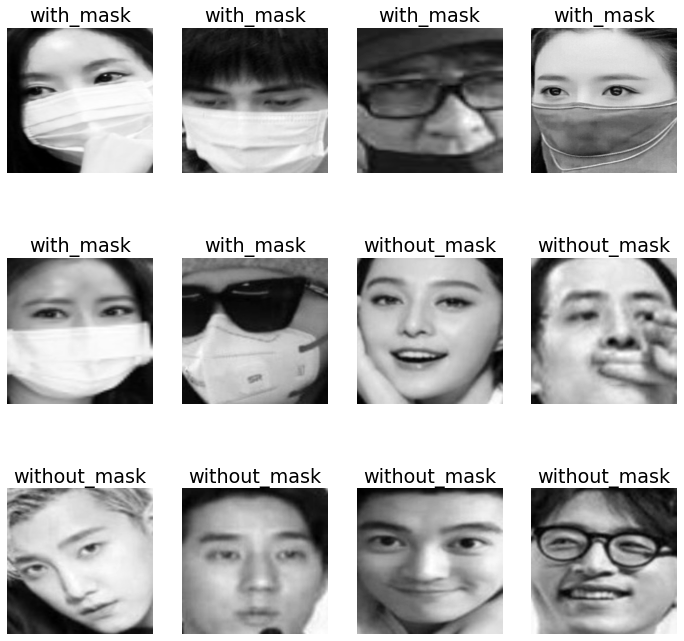

In [22]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize = (12, 12))
columns = 4
rows = 3

randomlist = []

for i in range(0, int((columns * rows)/2)):
    n = np.random.randint(0, np.count_nonzero(load_full_dataset[:,1] == 0))
    randomlist.append(n)
    
for i in range(0, int((columns * rows)/2)):
    n = np.random.randint(np.count_nonzero(load_full_dataset[:,1] == 0), len(load_full_dataset))
    randomlist.append(n)
    
for i in range(1, columns * rows + 1):
    rnd = np.random.randint(0, len(load_full_dataset))
    img = load_full_dataset[randomlist[i-1]][0]  
    fig.add_subplot(rows, columns, i)
    plt.title(labels[load_full_dataset[randomlist[i-1]][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [23]:
x_features = []
y_labels = []

for feature, label in load_full_dataset:
    x_features.append(feature)
    y_labels.append(label)
    
del load_full_dataset

In [24]:
x_features = np.array(x_features).reshape(-1, image_size, image_size, 1)
y_labels = np.array(y_labels)
y_labels = np.expand_dims(y_labels, axis =1)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_features, 
                                                    y_labels,
                                                    stratify = y_labels,
                                                    test_size = 0.2, 
                                                    random_state = 2)

del x_features, y_labels

In [26]:
print('\nTensor de features de treinamento:\t', x_train.shape, 
      '\nImagens:\t', len(x_train), 
      '\nSem máscara:\t', np.count_nonzero(y_train == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_train == 1))

print('\nTensor de labels de treinamento:\t', y_train.shape, 
      '\nQuantidade:\t', len(y_train),
      '\nSem máscara:\t', np.count_nonzero(y_train == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_train == 1))

print('\nTensor de features de teste:\t\t', x_test.shape, 
      '\nImagens:\t', len(x_test),
      '\nSem máscara:\t', np.count_nonzero(y_test == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_test == 1))

print('\nTensor de labels de teste:\t\t', y_test.shape, 
      '\nQuantidade:\t', len(y_test),
      '\nSem máscara:\t', np.count_nonzero(y_test == 0), 
      '\nCom máscara:\t', np.count_nonzero(y_test == 1))


Tensor de features de treinamento:	 (3524, 256, 256, 1) 
Imagens:	 3524 
Sem máscara:	 1762 
Com máscara:	 1762

Tensor de labels de treinamento:	 (3524, 1) 
Quantidade:	 3524 
Sem máscara:	 1762 
Com máscara:	 1762

Tensor de features de teste:		 (882, 256, 256, 1) 
Imagens:	 882 
Sem máscara:	 441 
Com máscara:	 441

Tensor de labels de teste:		 (882, 1) 
Quantidade:	 882 
Sem máscara:	 441 
Com máscara:	 441


In [27]:
x_train = x_train / 255
x_test  = x_test  / 255

In [28]:
i = Input(x_train.shape[1:], name="entrada")
a = Flatten(name="achatamento")(i)
a = Dense(512, activation = 'relu', name="densa1")(a)
a = Dropout(0.4, name="reducao1")(a)
a = Dense(512, activation = 'relu', name="densa2")(a)
a = Dropout(0.3, name="reducao2")(a)
a = Dense(512, activation = 'relu', name="densa3")(a)
a = Dropout(0.1, name="reducao3")(a)
a = Dense(1, activation = 'sigmoid', name="previsao")(a)

model_NN = Model(i,a, name='NN')

model_NN.compile(optimizer = 'SGD',
                 loss = "binary_crossentropy",
                 metrics = ["accuracy"])

#model_NN.compile(optimizer = tf.keras.optimizers.SGD(),
#                 loss = tf.keras.losses.BinaryCrossentropy(),
#                 metrics = [tf.keras.metrics.Accuracy()])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
i = Input(x_train.shape[1:], name="entrada")
b = Conv2D(32, (3,3), activation ='relu', padding = 'same', name="convolucao2d1")(i)
b = BatchNormalization(name="normalizacao1")(b)
b = Conv2D(32, (3,3), activation ='relu', padding = 'same', name="convolucao2d2")(b)
b = BatchNormalization(name="normalizacao2")(b)
b = MaxPooling2D(2,2, name="acumulacao1")(b)
b = Conv2D(64, (3,3), activation ='relu', padding = 'same', name="convolucao2d3")(b)
b = BatchNormalization(name="normalizacao3")(b)
b = Conv2D(64, (3,3), activation ='relu', padding = 'same', name="convolucao2d4")(b)
b = BatchNormalization(name="normalizacao4")(b)
b = MaxPooling2D(2,2, name="acumulacao2")(b)
b = Conv2D(128, (3,3), activation ='relu', padding = 'same', name="convolucao2d5")(b)
b = BatchNormalization(name="normalizacao5")(b)
b = Conv2D(128, (3,3), activation ='relu', padding = 'same', name="convolucao2d6")(b)
b = BatchNormalization(name="normalizacao6")(b)
b = MaxPooling2D(2,2, name="acumulacao3")(b)
b = Conv2D(256, (3,3), activation ='relu', padding = 'same', name="convolucao2d7")(b)
b = BatchNormalization(name="normalizacao7")(b)
b = Conv2D(256, (3,3), activation ='relu', padding = 'same', name="convolucao2d8")(b)
b = BatchNormalization(name="normalizacao8")(b)
b = MaxPooling2D(2,2, name="acumulacao4")(b)
b = Flatten(name="achatamento")(b)
b = Dense(512, activation = 'relu', name="densa1")(b)
b = Dropout(0.4, name="reducao1")(b)
b = Dense(512, activation = 'relu', name="densa2")(b)
b = Dropout(0.3, name="reducao2")(b)
b = Dense(512, activation = 'relu', name="densa3")(b)
b = Dropout(0.1, name="reducao3")(b)
b = Dense(1, activation = 'sigmoid', name="previsao")(b)

model_CNN = Model(i, b, name='CNN')

model_CNN.compile(optimizer = 'SGD',
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])

#model_CNN.compile(optimizer = tf.keras.optimizers.SGD(),
#                 loss = tf.keras.losses.BinaryCrossentropy(),
#                  metrics = [tf.keras.metrics.Accuracy()])

In [30]:
model_NN.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
achatamento (Flatten)        (None, 65536)             0         
_________________________________________________________________
densa1 (Dense)               (None, 512)               33554944  
_________________________________________________________________
reducao1 (Dropout)           (None, 512)               0         
_________________________________________________________________
densa2 (Dense)               (None, 512)               262656    
_________________________________________________________________
reducao2 (Dropout)           (None, 512)               0         
_________________________________________________________________
densa3 (Dense)               (None, 512)               262656   

In [31]:
model_CNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
convolucao2d1 (Conv2D)       (None, 256, 256, 32)      320       
_________________________________________________________________
normalizacao1 (BatchNormaliz (None, 256, 256, 32)      128       
_________________________________________________________________
convolucao2d2 (Conv2D)       (None, 256, 256, 32)      9248      
_________________________________________________________________
normalizacao2 (BatchNormaliz (None, 256, 256, 32)      128       
_________________________________________________________________
acumulacao1 (MaxPooling2D)   (None, 128, 128, 32)      0         
_________________________________________________________________
convolucao2d3 (Conv2D)       (None, 128, 128, 64)      18496   

In [32]:
batch_size = 32

train_gen = ImageDataGenerator(rotation_range = 10,
                               horizontal_flip = True,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               rescale = 1.,
                               zoom_range = 0.2,
                               fill_mode = 'nearest',
                               cval = 0)

train_generator_NN = train_gen.flow(x_train, y_train, batch_size)
train_generator_CNN = train_gen.flow(x_train, y_train, batch_size)

steps_per_epoch = x_train.shape[0] // batch_size

checkpoint_NN = ModelCheckpoint('../models/model_NN.h5', 
                                monitor = 'val_loss', 
                                verbose = 0, 
                                save_best_only = True, 
                                mode = 'auto')

checkpoint_CNN = ModelCheckpoint('../models/model_CNN.h5', 
                                 monitor = 'val_loss', 
                                 verbose = 0, 
                                 save_best_only = True, 
                                 mode = 'auto')

In [33]:
epochs = 10 # Reduce number of epochs for testing purposes

history_NN = model_NN.fit(train_generator_NN, 
                         validation_data = (x_test, y_test), 
                          steps_per_epoch = steps_per_epoch, 
                          epochs = epochs,
                          callbacks = [checkpoint_NN],
                          verbose = 2)

history_CNN = model_CNN.fit(train_generator_CNN, 
                            validation_data = (x_test, y_test), 
                            steps_per_epoch = steps_per_epoch, 
                            epochs = epochs,
                            callbacks = [checkpoint_CNN],
                            verbose = 2)

In [34]:
model_NN = tf.keras.models.load_model('../models/model_NN.h5')
model_CNN = tf.keras.models.load_model('../models/model_CNN.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
def plot_accuracy_hist(model_history, fig_title):

    plt.rcParams.update({'font.size': 14})

    fig = plt.figure(figsize = (16, 4))
    columns = 2
    rows = 1

    fig.suptitle(fig_title, fontsize = 20, y = 1.08)
    fig.add_subplot(rows, columns, 1)

    plt.title('Accuracy')
    #plt.ylim(0.6, 1)
    
    plt.plot(model_history.history['acc'], 
             color='green', 
             label = 'Train Accuracy')

    plt.plot(model_history.history['val_acc'], 
             color='red', 
             label = 'Test Accuracy', 
             linestyle='dashed')

    plt.legend()

    fig.add_subplot(rows, columns, 2)

    plt.title('Loss')
    plt.plot(model_history.history['loss'], 
             color='green', 
             label = 'Train Loss')

    plt.plot(model_history.history['val_loss'], 
             color='red', 
             label = 'Test Loss', 
             linestyle='dashed')

    plt.legend()

    plt.show()
    
plot_accuracy_hist(history_NN, 'Neural Network')
plot_accuracy_hist(history_CNN, 'Convolutional Neural Network')

NameError: name 'history_NN' is not defined

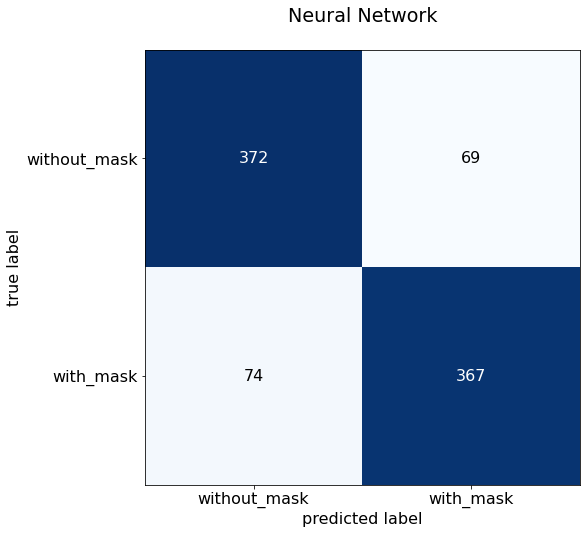

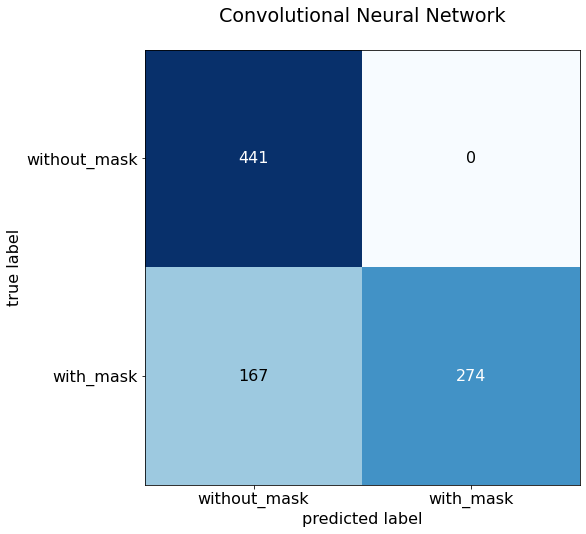

In [36]:
plt.rcParams.update({'font.size': 16})

def plot_confusion_mtx(model, x_test, plot_tittle):
    pred_prob = model.predict(x_test, batch_size = 8)
    pred = np.where(pred_prob > 0.5, 1,0)

    CM = confusion_matrix(y_test, pred)

    plot_confusion_matrix(conf_mat = CM, figsize = (16, 8))
    plt.title(plot_tittle)
    plt.xticks(range(2), labels)
    plt.yticks(range(2), labels)

    plt.show()

plot_confusion_mtx(model_NN, x_test, 'Neural Network')
plot_confusion_mtx(model_CNN, x_test, 'Convolutional Neural Network')

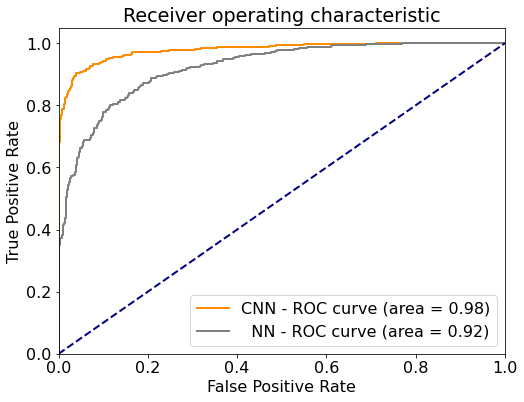

Classification Report - Neural Network
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       441
           1       0.84      0.83      0.84       441

    accuracy                           0.84       882
   macro avg       0.84      0.84      0.84       882
weighted avg       0.84      0.84      0.84       882


Classification Report - Convolutional Neural Network
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       441
           1       1.00      0.62      0.77       441

    accuracy                           0.81       882
   macro avg       0.86      0.81      0.80       882
weighted avg       0.86      0.81      0.80       882



In [39]:
pred_prob_NN  = model_NN.predict(x_test, batch_size = 8)
pred_prob_CNN = model_CNN.predict(x_test, batch_size = 8)

pred_NN  = np.where(pred_prob_NN > 0.5, 1,0)
pred_CNN = np.where(pred_prob_CNN > 0.5, 1,0)

NN_fpr, NN_tpr, _ = roc_curve(y_test, pred_prob_NN)
NN_roc_auc = auc(NN_fpr, NN_tpr)

CNN_fpr, CNN_tpr, _ = roc_curve(y_test, pred_prob_CNN)
CNN_roc_auc = auc(CNN_fpr, CNN_tpr)

plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize = (8, 6))

lw = 2
plt.plot(CNN_fpr,
         CNN_tpr, 
         color = 'darkorange',
         lw = lw, 
         label = 'CNN - ROC curve (area = %0.2f)' % CNN_roc_auc)

plt.plot(NN_fpr,
         NN_tpr, 
         color = 'grey',
         lw = lw, 
         label = '  NN - ROC curve (area = %0.2f)' % NN_roc_auc)

plt.plot([0, 1], [0, 1], 
         color = 'navy', 
         lw = lw, 
         linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")

plt.show()

print('Classification Report - Neural Network')
print(classification_report(y_test, pred_NN))

print('\nClassification Report - Convolutional Neural Network')
print(classification_report(y_test, pred_CNN))

In [38]:
print(datetime.now().strftime("%H:%M:%S"))

16:11:24
